In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as st

from surprise import Dataset, Reader, SVD, NMF
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
books_df = pd.read_csv("Books.csv", usecols=["ISBN", "Book-Title", "Book-Author", "Year-Of-Publication", "Publisher"])
ratings_df = pd.read_csv("Ratings.csv")
users_df = pd.read_csv("Users.csv", index_col="User-ID")

In [3]:
users_df.head(5)

,Location,Age
User-ID,,
1,"nyc, new york, usa",NaN
2,"stockton, california, usa",18.0
3,"moscow, yukon territory, russia",NaN
4,"porto, v.n.gaia, portugal",17.0
5,"farnborough, hants, united kingdom",NaN


In [4]:
books_df.head(3)
ratings_df.head(3)
#users_df.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


In [34]:
ratings_df['Book-Rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

In [5]:
def get_similar_objects(object_id, ratings_df, object_column, search_column):
    ratings = ratings_df.loc[ratings_df[object_column] == object_id]
    similar_objects = pd.DataFrame(columns = ratings.columns)
    for obj in ratings[search_column]:
        similar_objects = pd.concat([similar_objects, ratings_df.loc[(ratings_df[search_column] == obj) & (ratings_df[object_column] != object_id)]])
    return similar_objects.drop_duplicates(subset=[object_column])

In [6]:
def get_similarity(object1, object2, search_column):
    common_values = np.array(list(set(object1[search_column]) & set(object2[search_column])))
    object1 = object1[object1[search_column].isin(common_values)].sort_values(by=[search_column], ascending=True)
    object2 = object2[object2[search_column].isin(common_values)].sort_values(by=[search_column], ascending=True)
    if len(common_values) == 0:
        #print(f"Exit in ", 0)
        return 0
    correlation = np.corrcoef(object1['Book-Rating'].values, object2['Book-Rating'].values)[1, 0]
    if not np.isnan(correlation):
        return correlation
    else:
        return 1 - abs(object1['Book-Rating'].mean() - object2['Book-Rating'].mean())/10

In [7]:
def correlation_based_prediction(for_id, target_id, ratings_df, object_column, search_column, k=10):
    obj = ratings_df.loc[ratings_df[object_column] == for_id]
    similarities = get_similar_objects(for_id, ratings_df, object_column, search_column).apply(
        lambda x: get_similarity(ratings_df.loc[ratings_df[object_column] == x[object_column]], obj, search_column), axis=1)
    print(1)
    similarities = similarities.nlargest(k)
    k_closest =  ratings_df.loc[ratings_df[search_column] == target_id]
    k_closest = k_closest.loc[similarities.index.intersection(k_closest.index)]
    if len(k_closest) == 0:
        print("Ни один из ближайших соседей не оценил книгу с данным id")
        return np.nan

    similarities = similarities[k_closest.index]
    k_closest.loc[:, "Book-Rating"] = 10
    k_closest_mean = k_closest.apply(
        lambda x: ratings_df.loc[ratings_df[object_column] == x[object_column]]['Book-Rating'].mean(), axis=1)
    print(2)
    prediction = (obj['Book-Rating'].mean() + 
    sum(similarities * (k_closest['Book-Rating'] - k_closest_mean))/
    sum(similarities))
    if prediction < 0:
        prediction = 0
    elif prediction > 10:
        prediction = 10
    return prediction
    
def user_based(user_id, item_id, ratings_df, k=1000):
    return correlation_based_prediction(user_id, item_id, ratings_df, 'User-ID', 'ISBN', k)

def item_based(user_id, item_id, ratings_df, k=1000):
    return correlation_based_prediction(item_id, user_id, ratings_df, 'ISBN', 'User-ID', k)
    

#print(correlation_based_prediction(276746, '0786014512', ratings_df, 'User-ID', 'ISBN'))
print(user_based(276729, '006019491X', ratings_df))

1
Ни один из ближайших соседей не оценил книгу с данным id
nan


In [8]:
get_similar_objects(276729, ratings_df, 'User-ID', 'ISBN')

,User-ID,ISBN,Book-Rating


# Модель с кластеризацией

In [9]:
class ClusteringModel:
    def __init__(self, ratings_df):
        self.ratings_df = ratings_df
        self.user_item_matrix = pd.pivot_table(ratings_df[:50000], values='Book-Rating', index='User-ID', columns='ISBN')
        self.user_item_matrix.fillna(-1, inplace=True)
        self.user_similarity = cosine_similarity(self.user_item_matrix)
        self.reindexed_matrix = self.user_item_matrix.reset_index()
        
    def show_optimal_clusters(self):
        
        visualizer = KElbowVisualizer(KMeans(), k=(2,12))
        visualizer.fit(self.user_similarity)        # Fit the data to the visualizer
        visualizer.show()  
    
    def create_clusters(self, clusters_num):
        self.kmeans = KMeans(n_clusters=clusters_num, random_state=42)
        self.user_clusters = self.kmeans.fit_predict(self.user_similarity)
    
    def get_user_cluster(self, user_id):
        return self.kmeans.predict(self.user_similarity[self.reindexed_matrix.loc[self.reindexed_matrix['User-ID'] == 276729].index])
    
    def predict_rating(self, user_id, item_id):
        cluster = self.get_user_cluster(user_id)
        cluster_df = self.reindexed_matrix[self.user_clusters == cluster]
        cluster_ratings = cluster_df[item_id].loc[cluster_df[item_id] != -1]
        #if len(cluster_ratings) > 1:
        #   print(cluster_ratings)
        #   print(cluster_ratings.mean())
        return cluster_ratings.mean()

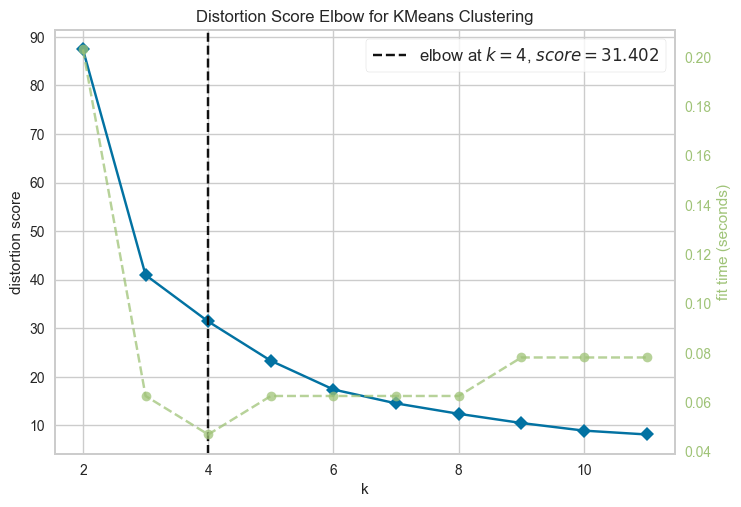

In [10]:
model = ClusteringModel(ratings_df.iloc[:1000])
model.show_optimal_clusters()

In [11]:

model.create_clusters(4)
model.get_user_cluster(276729)
for item in model.user_item_matrix.columns:
    model.predict_rating(276729, item)

In [12]:
model.reindexed_matrix

ISBN,User-ID,000225669X,0006379702,000651118X,0006511929,002542730X,00273755,0060002484,0060011939,0060094117,...,9508521481,9513098648,9681500830,9722900684,9726954835,9782922145441,9871138016,B0000BLD7X,B158991965,N3453124715
0,276725,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,276726,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,276727,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,276729,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,276733,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,277157,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
160,277159,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
161,277165,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
162,277168,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [22]:
model = ClusteringModel(ratings_df)



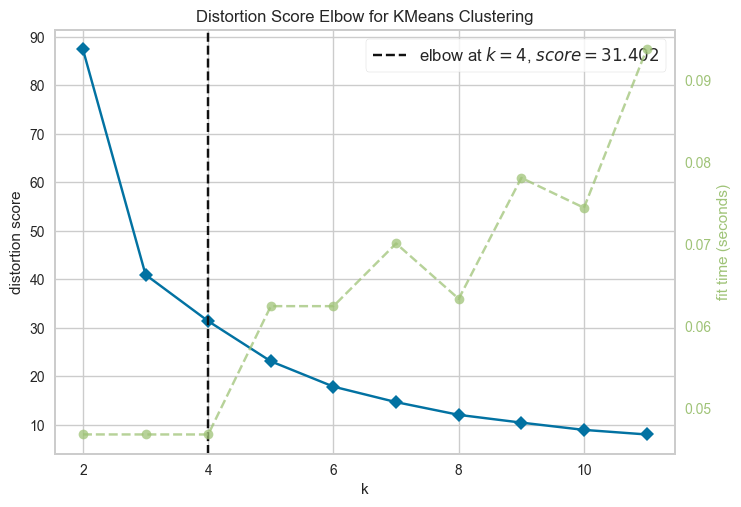

In [14]:
user_item_matrix = pd.pivot_table(ratings_df[:1000], values='Book-Rating', index='User-ID', columns='ISBN')
user_item_matrix.fillna(-1, inplace=True)

# Вычисление схожести пользователей
user_similarity = cosine_similarity(user_item_matrix)

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_similarity)

visualizer = KElbowVisualizer(kmeans, k=(2,12))
visualizer.fit(user_similarity)        # Fit the data to the visualizer
visualizer.show()  
# Определение оптимального числа кластеров
optimal_k = 4



# Проведение кластеризации с оптимальным k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_clusters = kmeans.fit_predict(user_similarity)

In [15]:
reseted_matrix = user_item_matrix.reset_index()
reseted_matrix.loc[reseted_matrix['User-ID'] == 276729].index
kmeans.predict(user_similarity[reseted_matrix.loc[reseted_matrix['User-ID'] == 276729].index])

array([1])

In [16]:
user_item_matrix[(user_item_matrix == user_item_matrix.loc[276729]).all(axis=1)]

ISBN,000225669X,0006379702,000651118X,0006511929,002542730X,00273755,0060002484,0060011939,0060094117,0060096195,...,9508521481,9513098648,9681500830,9722900684,9726954835,9782922145441,9871138016,B0000BLD7X,B158991965,N3453124715
User-ID,,,,,,,,,,,,,,,,,,,,,
276729,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [17]:
ratings_df.loc[ratings_df['User-ID'] == 276729]

,User-ID,ISBN,Book-Rating
3,276729,052165615X,3
4,276729,0521795028,6


In [18]:
kmeans.predict(user_similarity[150].reshape(1, -1))

array([1])

In [19]:
np.unique(user_clusters)

array([0, 1, 2, 3])

# Матричная факторизация

In [31]:

reader = Reader(rating_scale=(0, 10))
ratings_dataset = Dataset.load_from_df(ratings_df, reader=reader)
train, test = train_test_split(ratings_dataset, test_size=0.15)
algs = [SVD(), NMF()]
for alg in algs:
    alg.fit(train)
    predictions = alg.test(test)
    print(accuracy.rmse(predictions))

RMSE: 3.4960
3.496019301873556
RMSE: 3.9477
3.9477191147706234


In [33]:
for alg in algs:
    print(alg.predict(276729, '006019491X'))

user: 276729     item: 006019491X r_ui = None   est = 4.25   {'was_impossible': False}
user: 276729     item: 006019491X r_ui = None   est = 4.75   {'was_impossible': False}


In [27]:
alg.predict(276729, '006019491X')

Prediction(uid=276729, iid='006019491X', r_ui=None, est=4.671501825176401, details={'was_impossible': False})

In [29]:
ratings_df.loc[ratings_df['User-ID'] == 276729]

,User-ID,ISBN,Book-Rating
3,276729,052165615X,3
4,276729,0521795028,6
